In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from functools import partial

from estimagic import minimize

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

### Data Preparation

In [2]:
df = pd.read_excel("data/mydata.xlsx")

In [3]:
country_names = [
    "Australia",
    "Austria",
    "Belgium",
    "Canada",
    "Chile",
    "Czech Rep",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Israel",
    "Italy",
    "Japan",
    "Korea",
    "Luxembourg",
    "Mexico",
    "Netherlands",
    "New Zealand",
    "Norway",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "US",
    "GB",
]

country_names_dict = {i + 1: name for i, name in enumerate(country_names)}

In [4]:
df = df.assign(**{"name": df.country.replace(country_names_dict)})
df = df.set_index(["quarter", "name"]).sort_index()
df = df.drop("country", axis=1)

In [5]:
df.head()

loggdp
quarter name               
1       Australia -0.016800
        Austria   -0.010487
        Belgium   -0.008201
        Canada    -0.001922
        Chile     -0.039199

### Functions that implement SCM method

In [6]:
def transform_data(data, treatment_period, treated_country):
    y = df.loc[: treatment_period - 1, treated_country, :]
    X = df.loc[: treatment_period - 1, :, :].query("name != @treated_country")
    X = X.unstack()
    return y, X

In [7]:
def get_crit_func(y, X, weights, loss_type):
    def crit(params, y, X, loss_type):
        w = np.asarray(params["value"])
        if loss_type == "squared_error":
            loss = mean_squared_error
        elif loss_type == "absolute_error":
            loss = mean_absolute_error
        else:
            raise ValueError(
                "Loss type not implemented, must be in {'squared_error', 'absolute_error'}"
            )
        return loss(y, X @ w, sample_weight=weights)

    return partial(crit, y=y, X=X, loss_type=loss_type)

In [8]:
def synthetic_control(
    data,
    treatment_period,
    treated_country,
    loss_type="squared_error",
    weights=None,
    algorithm="scipy_lbfgsb",
):
    """Apply synthetic control method on our data setting.
    
    Args:
        ....
        
    Returns:
        pandas.DataFrame:
    
    """
    # build crit func
    y, X = transform_data(data, treatment_period, treated_country)

    crit_func = get_crit_func(y.values.flatten(), X.values, weights, loss_type)

    # build params start vector
    params = (
        pd.DataFrame(
            np.ones((X.shape[1], 1)), index=X.columns.droplevel(0), columns=["value"]
        )
        / X.shape[1]
    )
    params = (
        params.assign(**{"type": "weight"}).reset_index().set_index(["type", "name"])
    )

    # build constraint dict
    constraints = [{"loc": "weight", "type": "probability"}]

    # optimize
    result = minimize(crit_func, params, algorithm=algorithm, constraints=constraints)

    return result["solution_params"][["value"]]

In [35]:
def plot_results(data, result, treatment_period, periods=None, ylim=None):
    # preparation
    if periods is not None:
        data = data.query("quarter in @periods")
    
    treated_country = (
        set(data.index.get_level_values("name"))
        - set(result.index.get_level_values("name"))
    ).pop()
    X = data.unstack().droplevel(0, axis=1)
    synthetic = X.drop(treated_country, axis=1).dot(result.droplevel(0))

    df = X.assign(**{"treated": X[treated_country], "synthetic": synthetic})
    df = df.reset_index().melt(id_vars="quarter", value_name="loggdp")

    alpha = result.droplevel(0)
    alpha.loc["treated", "value"] = 1
    alpha.loc["synthetic", "value"] = 1

    df = df.merge(alpha.reset_index().rename({"value": "alpha"}, axis=1))

    # plotting
    fig, ax = plt.subplots(1)
    fig.set_size_inches(16, 12)

    p = sns.lineplot(
        x="quarter",
        y="loggdp",
        data=df.query("name in ['treated', 'synthetic']"),
        hue="name",
        ax=ax,
    )

    for country_name in df.name.unique():
        if country_name not in ["treated", "synthetic"]:
            _data = df.query("name == @country_name")
            sns.lineplot(
                x="quarter",
                y="loggdp",
                data=_data,
                alpha=_data["alpha"].unique()[0] * 2,
                ax=ax,
            )

    ax.axvline(treatment_period, color="grey", linestyle="--")
    scaler = ylim[1] * 3 / 4 if ylim is not None else 1
    ax.text(treatment_period, 1.05 * scaler, "Treatment Period", fontsize=14, ha="left")

    ax.legend(
        loc="upper left",
        bbox_to_anchor=(0.07, 0.75),
        frameon=False,
        labels=[f"Treated: {treated_country}", "Synthetic"],
        prop={"size": 14},
    )

    if ylim is not None:
        ax.set_ylim(ylim)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="Log-GDP", xlabel="Quarter")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    return ax

## Computation

In [31]:
treated_country = "GB"
treatment_period = 87

In [32]:
result = synthetic_control(df, treatment_period, treated_country)

<AxesSubplot:xlabel='Quarter', ylabel='Log-GDP'>

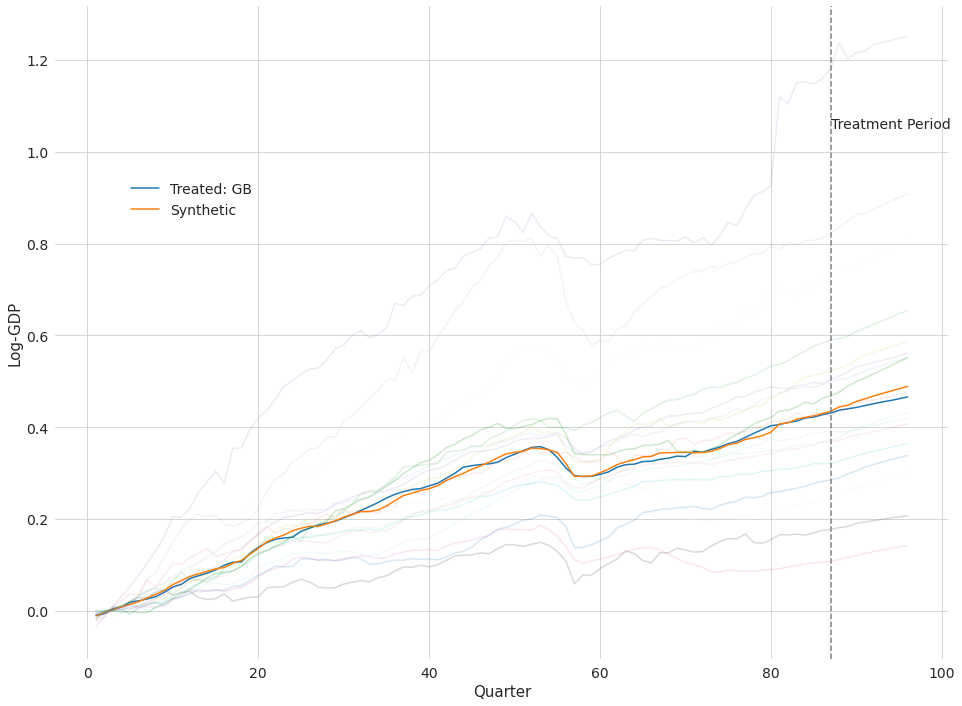

In [36]:
plot_results(df, result, treatment_period)

<AxesSubplot:xlabel='Quarter', ylabel='Log-GDP'>

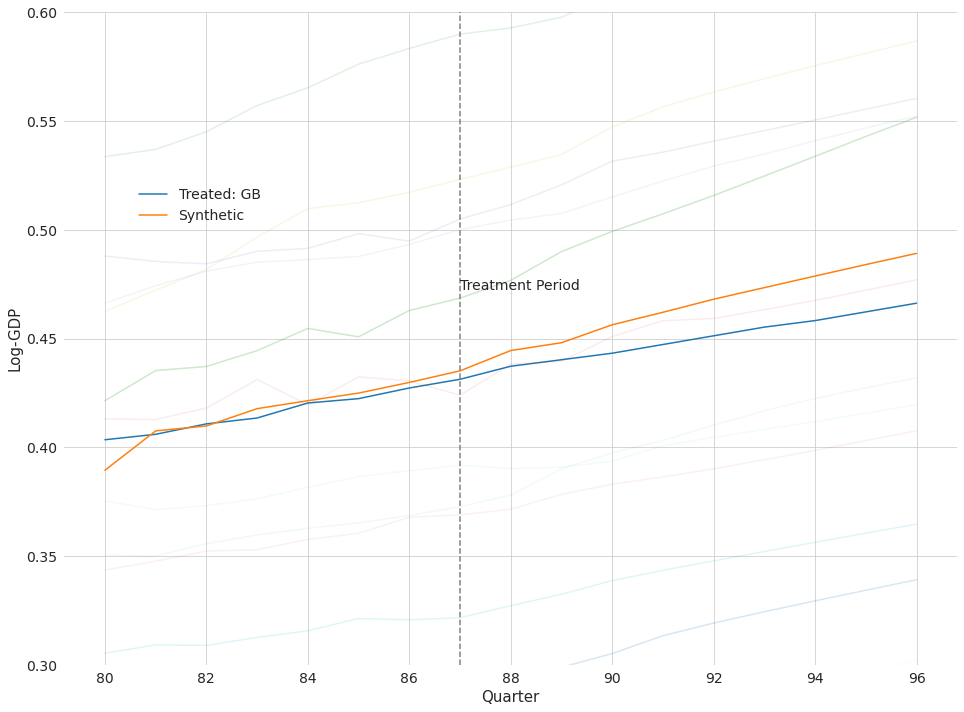

In [37]:
plot_results(df, result, 87, range(80, 97), (0.3, 0.6))